<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
# !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Convert to date time object


In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [6]:
# # notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

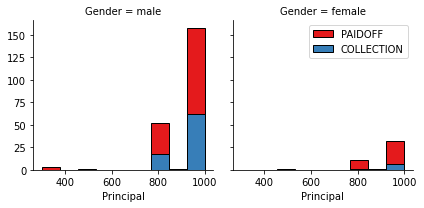

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

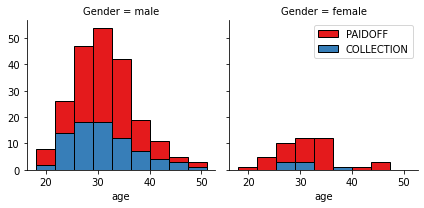

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


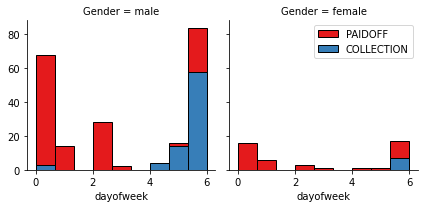

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [18]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Split the dataset into training and validation set
trainX, validX, trainy, validy = train_test_split(X, y, test_size = 0.3, random_state = 0)

### K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [22]:
# List of k's and the corresponding test accuracy scores to find the best k
ks, kaccs = [], []
# The minimum Jaccardian score any model can have
minacc = 0
# The optimal k
optk = 0
# The optimal KNN model
modelKNN = None
# Loop to iterate through different values of k from 1 to 20 and populate the above lists with the corresponding values to evaluate the best k
for k in range(1, 21):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(trainX, trainy)
    yhat = classifier.predict(validX)
    acc = accuracy_score(validy, yhat)
    ks.append(k)
    kaccs.append(acc)
    # If this is the best accuracy achieved by far, assign the model to modelKNN
    if acc > minacc:
        minacc = acc
        modelKNN = classifier
        optk = k

In [23]:
# Print the optimal k
print(f"So the optimal k is  {optk}")

So the optimal k is  11


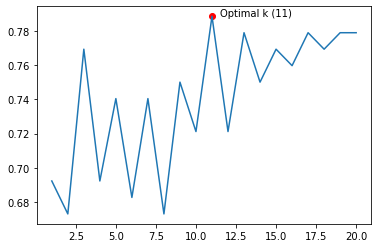

In [24]:
# Plot the values of k vs the accuracies
plt.plot(ks, kaccs)
# Plot the point corresponding to the most optimal k
plt.scatter(optk, kaccs[optk - 1], color = "red")
plt.annotate(f"Optimal k ({optk})", (optk, kaccs[optk - 1]), (optk + 0.5, kaccs[optk - 1]))
plt.show()

In [25]:
# Train the model using the full dataset
modelKNN.fit(X, y)

KNeighborsClassifier(n_neighbors=11)

So **modelKNN** represents the best K-Nearest Neighbors model according to the above analysis using a validation set

### Decision Tree


In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
# Initialize the Decision Tree model
modelDT = DecisionTreeClassifier()

In [28]:
# Train the model using the whole dataset
modelDT.fit(X, y)

DecisionTreeClassifier()

So **modelDT** represents the Decision Tree model

### Support Vector Machine


In [29]:
from sklearn.svm import SVC

In [30]:
# Initialize the Support Vector Machine model
modelSVM = SVC()

In [31]:
# Train the model using the whole dataset
modelSVM.fit(X, y)

SVC()

So **modelSVM** represents the Support Vector Machine model

### Logistic Regression


In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
# Initialize the Logistic Regression model
modelLR = LogisticRegression()

In [34]:
# Train the model using the whole dataset
modelLR.fit(X, y)

LogisticRegression()

So **modelLR** represents the Logistic Regression model

# Model Evaluation using Test set


In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [36]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [38]:
# Obtain the test values corresponding to our target variable
testy = test_df["loan_status"].values
testy[:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [39]:
# Convert the "effective_date" column to datetime format
test_df["effective_date"] = pd.to_datetime(test_df["effective_date"])
# Obtain the Day of the week ("dayofweek") from the previously modified column
test_df["dayofweek"] = test_df["effective_date"].dt.dayofweek
# Obtain the "weekday" column which has values 1 (if "dayofweek" is greater than 0) and 0 (otherwise)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

In [40]:
# Replace the string values in the "Gender" column with numerical values (0 and 1)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

In [41]:
testX = test_df[['Principal','terms','age','Gender','weekend']]
# One-Hot encode the "education" column
testX = pd.concat([testX, pd.get_dummies(test_df['education'])], axis = 1)
# Drop the unnecessary column
testX.drop(['Master or Above'], axis = 1,inplace=True)

# View the dataframe
testX.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [42]:
# Obtain the test set corresponding to our predictor variables
testX = testX.values

In [43]:
# Standardize the values
testX = preprocessing.StandardScaler().fit_transform(testX)
testX[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

## Predict Using the Different Models

### KNN

In [44]:
yknn = modelKNN.predict(testX)

### Decision Tree

In [45]:
ydt = modelDT.predict(testX)

### SVM

In [46]:
ysvm = modelSVM.predict(testX)

### Logistic Regression

In [47]:
ylr = modelLR.predict(testX)

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [48]:
initvals = np.array([np.nan] * 4)
# Initialize the report dataframe
report = pd.DataFrame({"Algorithm" : ["KNN", "Decision Tree", "SVM", "Logistic Regression"], "Jaccard" : initvals, "F1-score" : initvals, "LogLoss" : [np.nan, np.nan, np.nan, np.nan]})
report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,NaN,NaN,NaN
1,Decision Tree,NaN,NaN,NaN
2,SVM,NaN,NaN,NaN
3,Logistic Regression,NaN,NaN,NaN


In [49]:
# List of the predicted values corresponding to the models
yhats = [yknn, ydt, ysvm, ylr]

# Use loops to calculate Jaccardian and F1 scores for each of the model and add them to the report
for i in range(4):
    yhat = yhats[i]
    score = accuracy_score(testy, yhat)
    report.iloc[i, 1] = score
for i in range(4):
    yhat = yhats[i]
    score = f1_score(testy, yhat, pos_label = "PAIDOFF")
    report.iloc[i, 2] = score

# Replace the string categories in real and predicted set with numeric ones (0 and 1) in the case of the logistic regression model for log loss score
testylr = pd.Series(testy).replace(to_replace = ["COLLECTION", "PAIDOFF"], value = [0, 1]).values
ylr = pd.Series(ylr).replace(to_replace = ["COLLECTION", "PAIDOFF"], value = [0, 1]).values
# Add the LogLoss score for the logistic regression model
report.iloc[3, 3] = log_loss(testylr, ylr)

### Here is the REPORT

In [50]:
# Replace the null values with "NA"
report.replace(to_replace = [np.nan], value = ["NA"], inplace = True)
report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.685185,0.804598,NA
1,Decision Tree,0.685185,0.78481,NA
2,SVM,0.722222,0.83871,NA
3,Logistic Regression,0.759259,0.860215,8.315083


# Print the Various Accuracy Scores for Each Model

### KNN

In [51]:
print(f"KNN Jaccardian score:  {report.iloc[0, 1]}")
print(f"KNN F1 score:  {report.iloc[0, 2]}")

KNN Jaccardian score:  0.6851851851851852
KNN F1 score:  0.8045977011494252


### Decision Tree

In [52]:
print(f"Decision Tree Jaccardian score:  {report.iloc[1, 1]}")
print(f"Decision Tree F1 score:  {report.iloc[1, 2]}")

Decision Tree Jaccardian score:  0.6851851851851852
Decision Tree F1 score:  0.7848101265822786


### SVM

In [53]:
print(f"SVM Jaccardian score:  {report.iloc[2, 1]}")
print(f"SVM F1 score:  {report.iloc[2, 2]}")

SVM Jaccardian score:  0.7222222222222222
SVM F1 score:  0.8387096774193549


### Logistic Regression

In [54]:
print(f"Logistic Regression Jaccardian score:  {report.iloc[3, 1]}")
print(f"Logistic Regression F1 score:  {report.iloc[3, 2]}")
print(f"Logistic Regression Log Loss:  {report.iloc[3, 3]}")

Logistic Regression Jaccardian score:  0.7592592592592593
Logistic Regression F1 score:  0.8602150537634409
Logistic Regression Log Loss:  8.315083109267249


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
